# Spatial variations in Chicago's PurpleAir sensor data

There is evidence [1] that there tends to be significant variation in the PM2.5 concentration within urban areas (say, neighborhood to neighborhood) and that health outcomes are correlated with these variations. In this notebook, we consider the concentrations measured by the PurpleAir sensors throughout the Chicago area and study how they vary in space.

[1] Long-Term Exposure to Air Pollution and Incidence of Cardiovascular Events in Women. DOI: https://doi.org/10.1056/nejmoa054409

## Analysis

### Imports and utility

In [1]:
# TODO:
# - redo ALL of this (!?!) with multi-indices, which is probably a cleaner approach?
# - or perhaps reconceptualize as only looking at an hourly slice
#       that is, the analysis in this notebook is a function of an hourly slice

In [2]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', str)

Note that in this notebook (unlike some of our other notebooks), both `a` and `b` channels associated to a sensor are assigned the same `sensorID`. In other notebooks the two channels' IDs differ by 1.

The datetime column is a bit hard to work with for data exploration/visualization purposes, so we'll add a column that measures the hours elapsed from the minimum value observed in the whole DataFrame.

In [3]:
df = pd.read_csv('../data/chicago_data.csv', index_col = 0)
df.rename(columns = {'sensorID': 'sensor'}, inplace = True)

df['datetime'] = pd.to_datetime(df['datetime'])
min_time = df['datetime'].min()
df['hours_elapsed'] = (df['datetime'] - min_time) / timedelta(hours = 1)

sensors = df['sensor'].unique()

df.head().round(4)

,sensor,latitude,longitude,name,channel,datetime,pm25,temp,rh,hours_elapsed
0,3499,41.8927,-87.6857,Ukrainian Village,a,2022-01-30 00:00:22+00:00,0.0,26.0,42.0,0.0058
1,3499,41.8927,-87.6857,Ukrainian Village,a,2022-01-30 00:02:21+00:00,0.45,26.0,42.0,0.0389
2,3499,41.8927,-87.6857,Ukrainian Village,a,2022-01-30 00:04:22+00:00,0.0,26.0,42.0,0.0725
3,3499,41.8927,-87.6857,Ukrainian Village,a,2022-01-30 00:06:21+00:00,0.61,26.0,42.0,0.1056
4,3499,41.8927,-87.6857,Ukrainian Village,a,2022-01-30 00:08:21+00:00,0.0,26.0,42.0,0.1389


### Cleaning data

#### Missing data

Let us first check for missing data. We expect there to be a lot of missing data in the `b` channels, as there the temperature and relative humidity columns are not actually what they're labelled (see [here](https://docs.google.com/document/d/15ijz94dXJ-YAZLi9iZ_RaBwrZ4KtYeCy08goGBwnbCU/) for details). We will be keeping the `a` channel's measurements of those two variables.

There are, however, two sensors (the sensors labelled `Studio Gang` and `La Paz - Dickens (Roof)`) that are missing temperature and relative humidity data. This missing data makes it more difficult to apply any EPA correction factors (though not impossible, as we might just use temperatures from nearby sensors). However, if we're focusing solely on PurpleAir sensors, it may not be important.

any null pm2.5 values? False
0.0        3038
10.98        48
11.98        40
3.0          40
11.93        40
           ... 
6885.22       1
6764.55       1
6867.32       1
6794.21       1
6872.3        1
Name: pm25, Length: 6055, dtype: int64


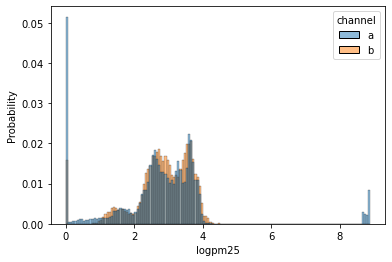

In [4]:
print(f'any null pm2.5 values? {df["pm25"].isnull().any()}')
print(df['pm25'].value_counts())
df['logpm25'] = df['pm25'].apply(np.log1p)
sns.histplot(data = df, x = 'logpm25', stat = 'probability', hue = 'channel');

In [5]:
df_ch_a_missing = df[df['channel'] == 'a'][df[df['channel'] == 'a'].isnull().any(axis = 1)]
df_ch_a_missing['name'].value_counts()

La Paz - Dickens (Roof)    700
Studio Gang                700
Name: name, dtype: int64

Note, in this histogram, two concerning aspects of this distribution of PM2.5 concentrations. First, there are a large number of measurements of 0, which could be valid, depending on how the sensors report low concentrations, but probably represents the lack of a valid concentration value. Second, there are a number of extremely large measurements (roughly 7,000 ug/m^3), which are likely entirely spurious.

One way to hopefully deal with both of these problems at once is to take advantage of the fact that each sensor has two channels. We can compare the `a` and `b` channels of every sensor and throw out data from sensors for which we find large discrepancies.

#### Channel mismatch ($R^2\geqslant 0.9, \text{RMSE}\leqslant 5$)

Notice that the times at which the a and b channels take measurements may be offset by a few seconds. This should  not change whether or not the two channels have similar measurements, so we'll ignore this issue.

In [6]:
max_offsets = {}
for sensor in sensors:
    df_sensor_a = df[(df['sensor'] == sensor) & (df['channel'] == 'a')]
    df_sensor_b = df[(df['sensor'] == sensor) & (df['channel'] == 'b')]
    max_offsets[sensor] = (df_sensor_a['hours_elapsed'].reset_index(drop = True) - df_sensor_b['hours_elapsed'].reset_index(drop = True)).max()
#display(max_offsets)

We can compute, for each sensor, the correlation between the two channels.

In [7]:
df_correlations = pd.DataFrame()

for sensor in sensors:
    df_sensor_a = df[(df['sensor'] == sensor) & (df['channel'] == 'a')].reset_index(drop = True)
    df_sensor_b = df[(df['sensor'] == sensor) & (df['channel'] == 'b')].reset_index(drop = True)
    corr = df_sensor_a['pm25'].corr(df_sensor_b['pm25'])
    rmse = np.sqrt((df_sensor_a['pm25'] - df_sensor_b['pm25']).pow(2).mean())
    df_correlations = df_correlations.append({'sensor': sensor, 'corr': corr, 'rmse': rmse}, ignore_index = True)
df_correlations.set_index('sensor', drop = True, inplace = True)
df_correlations.round(4)

,corr,rmse
sensor,,
3499.0,0.644,20.3456
4395.0,0.9927,1.2194
5554.0,NaN,0.0
5588.0,NaN,19.9946
5670.0,0.9761,8.1218
5762.0,0.9901,7.3481
5774.0,0.9668,4.6398
7920.0,0.9918,5.3668
140102.0,0.992,3.3732


If we restrict to sensors for which the `a` and `b` channels are correlated very strongly ($R^2\geqslant 0.9$) and for which they report similar values ($\text{RMSE} \leqslant 5$), we end up with 18 sensors with useable data in this timeframe.

In [8]:
df_acceptable = df_correlations[(df_correlations['corr'] >= 0.9) & (df_correlations['rmse'] <= 5)]
display(df_acceptable.round(4).T)
df_acceptable.describe().T.round(4)

sensor,4395.0,5774.0,140102.0,10416.0,36281.0,51943.0,56135.0,87741.0,95801.0,96079.0,96815.0,100261.0,101643.0,109598.0,113494.0,120369.0,124611.0,128349.0
corr,0.9927,0.9668,0.992,0.9934,0.9772,0.994,0.9932,0.9919,0.9939,0.9928,0.9704,0.9937,0.9875,0.9897,0.9928,0.9815,0.9675,0.9966
rmse,1.2194,4.6398,3.3732,1.2936,2.2122,1.5454,3.0208,4.3386,1.6133,2.1371,2.3205,3.5139,2.7133,2.054,1.4785,4.0332,2.7999,4.1039


,count,mean,std,min,25%,50%,75%,max
corr,18.0,0.9871,0.0099,0.9668,0.983,0.9924,0.9933,0.9966
rmse,18.0,2.6895,1.1039,1.2194,1.7235,2.5169,3.4787,4.6398


### Exploratory visualization

Without restricting to more 'reliable' sensors, we obtain the following timeseries for PM2.5 concentrations over the course of the day (the x-axis here being the 24hour time).

/tmp/ipykernel_4078/971687435.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


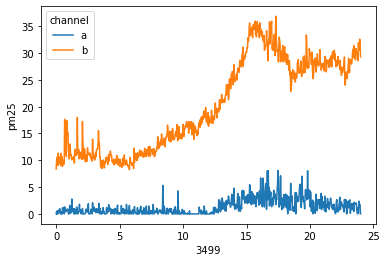

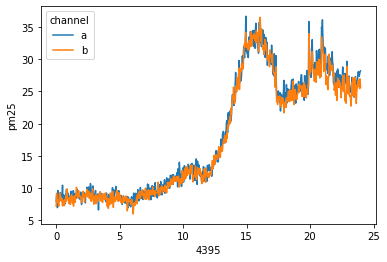

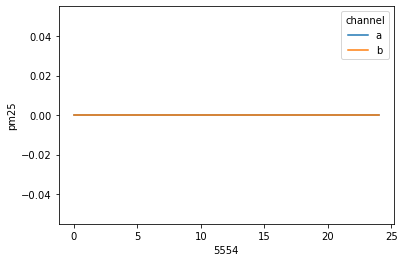

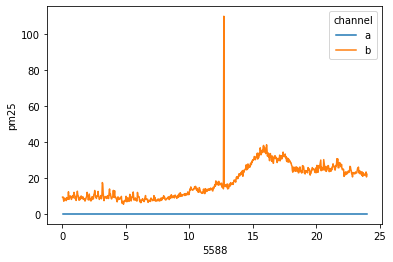

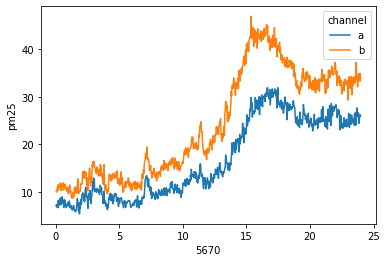

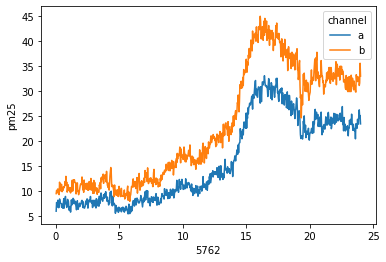

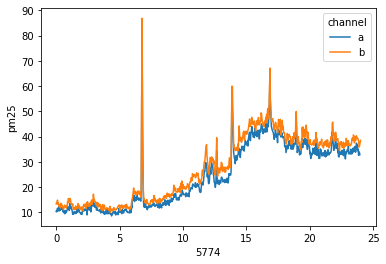

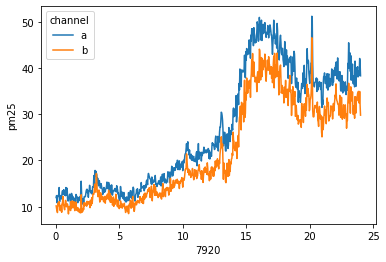

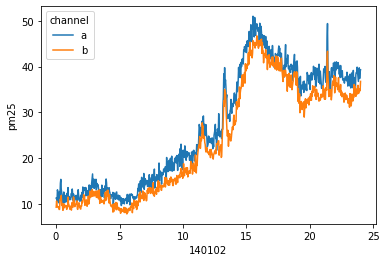

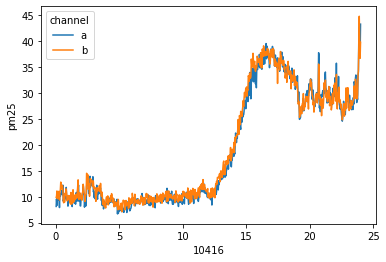

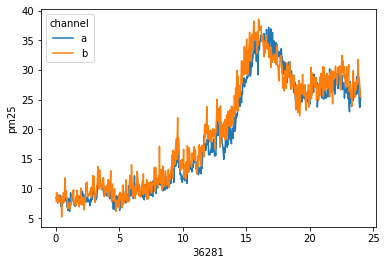

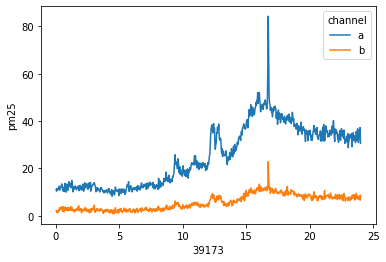

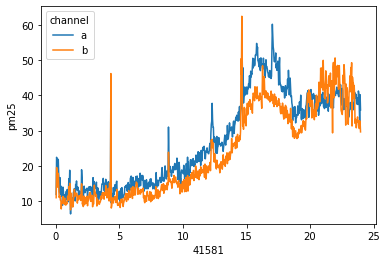

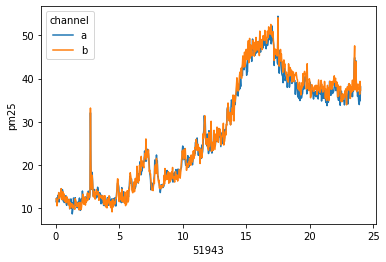

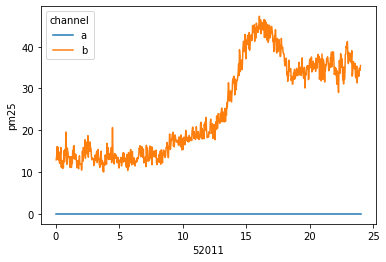

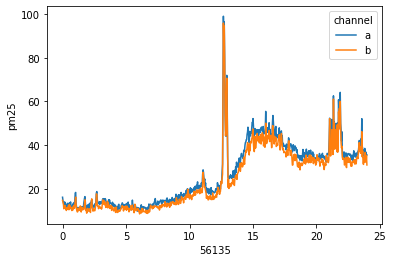

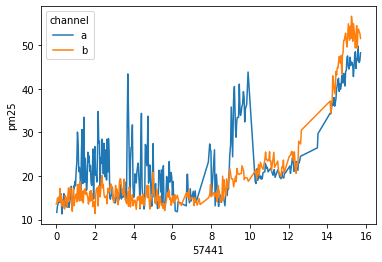

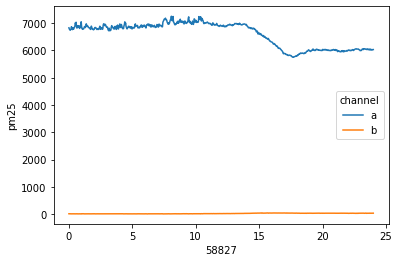

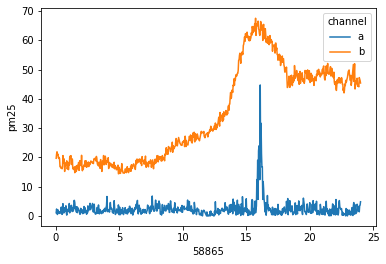

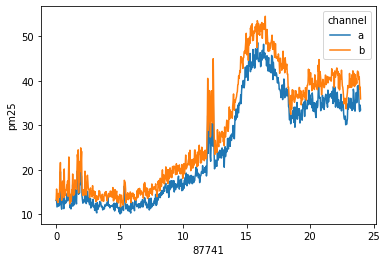

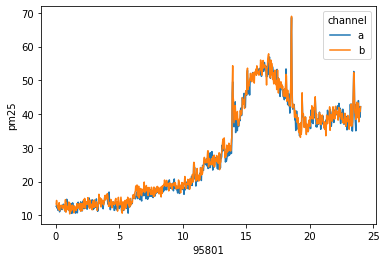

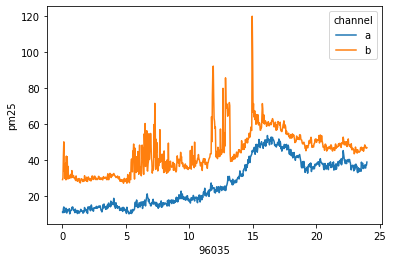

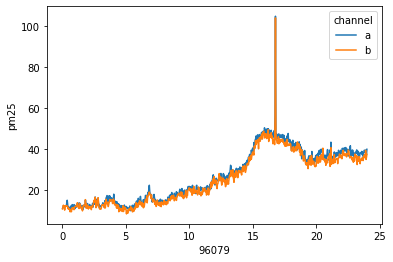

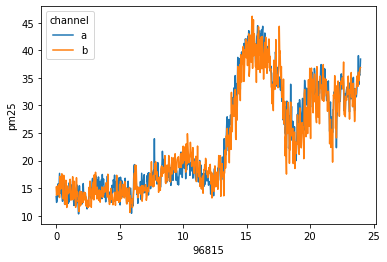

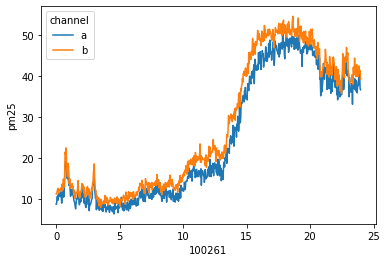

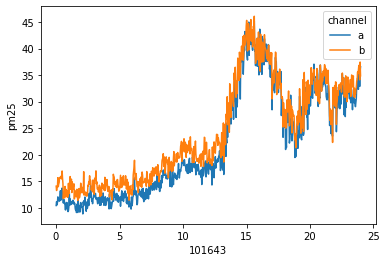

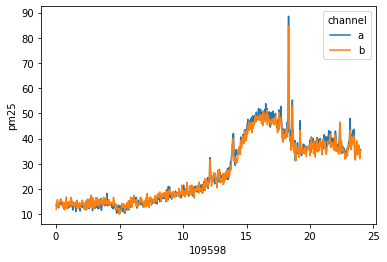

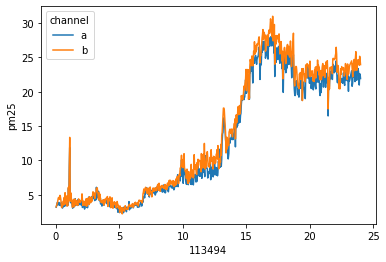

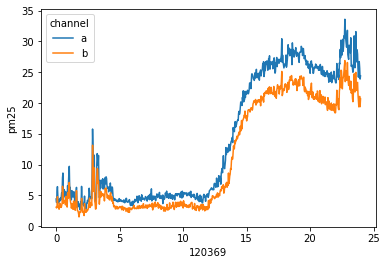

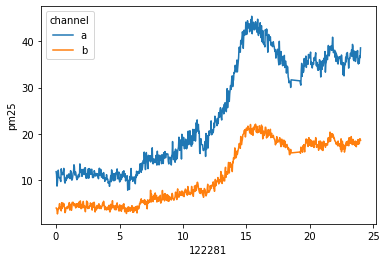

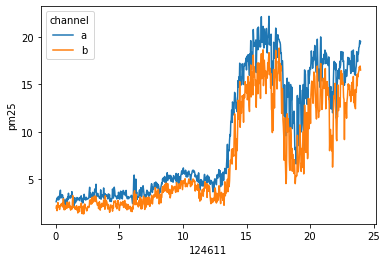

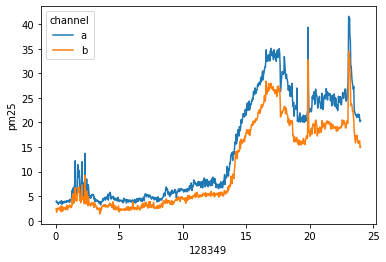

In [9]:
for sensor in sensors:
    plt.figure()
    ax = sns.lineplot(data = df[df['sensor'] == sensor], x = 'hours_elapsed', y = 'pm25', hue = 'channel');
    ax.set_xlabel(sensor)

Let's restrict now to the 'reliable' sensors. Let's average their readings by the hour to smoothen out the variablility and make the `a` and `b` timestamps immediately comparable. We then average the two channels to obtain a single concentration hourly concentration reading for each sensor.

In [10]:
# TODO there's gotta be a better way to do this!
df_hourly_grouped = df[df['sensor'].isin(df_acceptable.index)].groupby(['sensor', 'channel'])
sensor_channel_groups = []
for (key, data) in df_hourly_grouped:
    data = data.groupby(pd.Grouper(key = 'datetime', freq = 'H')).mean()
    data['channel'] = key[1]
    sensor_channel_groups.append(data)
df_hourly = pd.concat(sensor_channel_groups)
del df_hourly['hours_elapsed']
del df_hourly['logpm25']
df_hourly.round(2);

In [11]:
df_hourly['sensor'].value_counts();

In [12]:
# we have to merge the a and b channels along the time-of-measurement
# df_hourly[df_hourly['channel'] == 'a'].reset_index().merge(df_hourly[df_hourly['channel'] == 'b'][['pm25']].reset_index(), how = 'inner', on = ['datetime', 'sensor'], indicator = True)
# TODO ^ that doesn't work for some reason that I can't fathom, so we'll just do it manually
df_hourly_a = df_hourly[df_hourly['channel'] == 'a']
df_hourly_b = df_hourly[df_hourly['channel'] == 'b']
df_hourly_a = df_hourly_a.assign(pm25_b = df_hourly_b['pm25'])
df_hourly_a['pm25_avg'] = (df_hourly_a['pm25'] + df_hourly_a['pm25_b']) / 2
df_hourly_a['hours_elapsed'] = (df_hourly_a.index - df_hourly_a.index[0]) / timedelta(hours = 1)
df_hourly_a.head().round(4)

,sensor,latitude,longitude,pm25,temp,rh,channel,pm25_b,pm25_avg,hours_elapsed
datetime,,,,,,,,,,
2022-01-30 00:00:00+00:00,4395,41.996,-87.692,8.647,32.0,34.8333,a,8.226,8.4365,0.0
2022-01-30 01:00:00+00:00,4395,41.996,-87.692,8.8057,32.1667,35.6333,a,8.499,8.6523,1.0
2022-01-30 02:00:00+00:00,4395,41.996,-87.692,9.153,31.9333,36.2667,a,8.7507,8.9518,2.0
2022-01-30 03:00:00+00:00,4395,41.996,-87.692,8.706,32.2333,36.8333,a,8.5323,8.6192,3.0
2022-01-30 04:00:00+00:00,4395,41.996,-87.692,8.7667,31.9,37.7333,a,8.33,8.5483,4.0


Let's take a look at the timeseries from the 'reliable' sensors in the Chicago Air. Again, this is 2-channel-averaged PM2.5 concentration data plotted against the 24hour time of the chosen day.

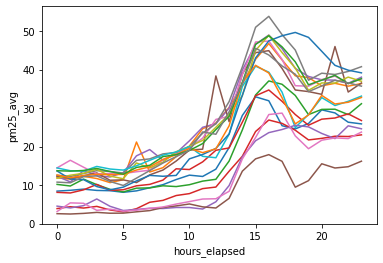

In [13]:
# display the 'reliable' sensors' timeseries
for sensor in df_hourly_a['sensor'].unique():
    #plt.figure()
    df_to_plot = df_hourly_a[df_hourly_a['sensor'] == sensor]
    ax = sns.lineplot(data = df_to_plot, x = 'hours_elapsed', y = 'pm25_avg');

### Spatial variation

Let's take an initial look at how the readings vary in space. Note that the variation is not too large -- well within the green and yellow ranges of the AQI color scale.

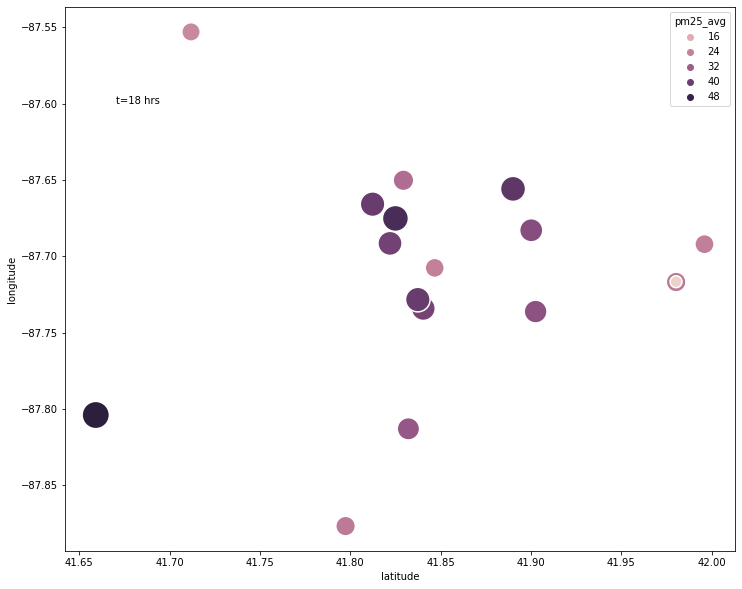

In [14]:
t = 18
df_3dscatter = df_hourly_a[df_hourly_a['hours_elapsed'] == t]

fig = plt.figure(figsize = (12, 10))
ax = sns.scatterplot(x = df_3dscatter['latitude'], y = df_3dscatter['longitude'], s = df_3dscatter['pm25_avg'] * 15, hue = df_3dscatter['pm25_avg'])
ax.text(x = 41.67, y = -87.6, s = f't={t} hrs');

How should we think about the variation in these measurements? Well first off, notice that the sensors may be performing measurements under disparate relative humidities. This can nontrivially affect the concentration readings. We can try to normalize for relative humidity by applying the US EPA correction formula. This formula is an accuracy correction formula used to compare PurpleAir readings to FRM/FEM readings. It includes a term accounting for the relative humidity, and so is an easy way to simultaneously control for humidity and also obtain values immediately comparable to readings from the AirNow monitors.

A first quick statistic to look at is the standard deviation in the set of measurements taken by these monitors at, say, 6pm. This gives us a notion of how different the PM2.5 concentrations can be at a given point in time. In fact let's take a look at how the standard deviation changes over the course of the day.

,sensor,latitude,longitude,pm25,temp,rh,channel,pm25_b,pm25_avg,hours_elapsed,pm25_avg_corr
datetime,,,,,,,,,,,
2022-01-30 18:00:00+00:00,4395,42.0,-87.69,25.04,46.23,37.63,a,24.13,24.59,18.0,15.3
2022-01-30 18:00:00+00:00,5774,41.84,-87.73,36.69,43.64,37.64,a,40.06,38.38,18.0,22.47
2022-01-30 18:00:00+00:00,10416,41.83,-87.81,33.38,49.6,28.73,a,33.18,33.28,18.0,20.57
2022-01-30 18:00:00+00:00,36281,41.83,-87.65,28.45,45.37,35.3,a,28.19,28.32,18.0,17.44
2022-01-30 18:00:00+00:00,51943,41.84,-87.73,39.57,35.9,51.63,a,41.02,40.29,18.0,22.27
2022-01-30 18:00:00+00:00,56135,41.9,-87.74,36.78,34.93,50.77,a,32.61,34.69,18.0,19.43
2022-01-30 18:00:00+00:00,87741,41.9,-87.68,33.73,35.17,49.4,a,37.86,35.8,18.0,20.13
2022-01-30 18:00:00+00:00,95801,41.82,-87.68,44.95,37.43,47.2,a,45.18,45.07,18.0,25.13
2022-01-30 18:00:00+00:00,96079,41.81,-87.67,41.06,38.8,44.73,a,39.72,40.39,18.0,22.91


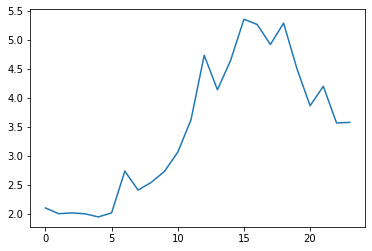

In [15]:
# US EPA correction formula (see the accuracy correction notebook for some details)
def correction_epa(pm25, rh):
    return 0.52 * pm25 - 0.085 * rh + 5.71

# TODO are there any sensors with no RH? doesn't look like it, but double check later
df_hourly_a['pm25_avg_corr'] = df_hourly_a.apply(lambda row: correction_epa(row['pm25_avg'], row['rh']), axis = 1)

# spit out a table for 6pm to get a sense of the numbers
t = 18
df_3dscatter = df_hourly_a[df_hourly_a['hours_elapsed'] == t]
display(df_3dscatter.round(2))

# plot the standard deviation as a time series
std_corrs = []
for t in range(24):
    df_hourly_t = df_hourly_a[df_hourly_a['hours_elapsed'] == t]
    std_corrs.append(df_hourly_t['pm25_avg_corr'].std())
std_corrs
sns.lineplot(data = std_corrs);

The standard deviation caps out (roughly in the afternoon) at about 5.5ug/m^3 (recall that we have applied the US EPA correction formula). This is not a large deviation in the context of AQI categories. On the other hand, the reference [1] from above estimated that every 10ug/m^3 of increased PM2.5 levels corresponded to a 24% increase in the risk of a cardiovascular event. In that respect, it is possible that such variation can correspond to variation in health outcomes.

#### TODO measuring variation --- hypothesis testing, goodness-of-fit, ...?
The standard deviation is a fairly simplistic measure of variation and it's not clear how 'significant' a variation of 5.5ug/m^3 is. Typically when we think of significance we thinking of something like a z-score, where we measure how likely it is that an outcome occurred due to random chance. In these situtations, we have a known distribution from which we are sampling under the null hypothesis.

### TODO summer season analysis, summer tends to have higher concentrations
### TODO NAAQS thresholds (obviously don't have 3yr data but...)

### TODO Social vulnerability

### Nearby AirNow vs PurpleAir

,latitude,longitude,class
0,41.659073,-87.803925,pa
1,41.7118,-87.55293,pa
2,41.79734,-87.876686,pa
3,41.81229,-87.66579,pa
4,41.82193,-87.69146,pa
5,41.82493,-87.675125,pa
6,41.82936,-87.65014,pa
7,41.83212,-87.81295,pa
8,41.837326,-87.72829,pa
9,41.840347,-87.73412,pa


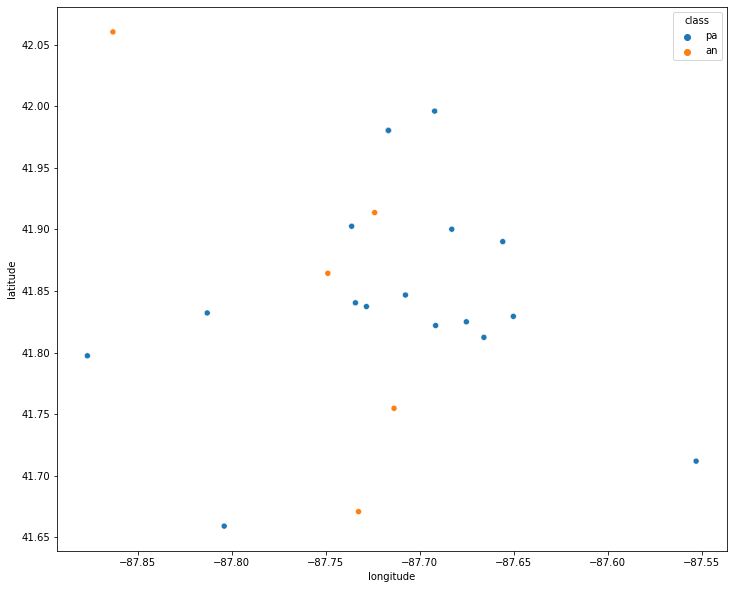

In [28]:
locations_an = {'Alsip': (41.6708, -87.7325),
                'Springifield Pump': (41.7547, -87.7136),
                'Cicero': (41.8643, -87.7488),
                'Com Ed': (41.9136, -87.7239),
                'Des Plaines': (42.0603, -87.8631)}
df_locations = df_hourly_a[['latitude', 'longitude']].round(7).reset_index(drop = True).drop_duplicates().sort_values(by = 'latitude')
df_locations['class'] = 'pa'
for location in locations_an:
    (x, y) = locations_an[location]
    df_locations = df_locations.append({'latitude': x,
                                        'longitude': y,
                                        'class': 'an'}, ignore_index = True)
display(df_locations)

fig = plt.figure(figsize = (12, 10))
ax = sns.scatterplot(data = df_locations, y = 'latitude', x = 'longitude', hue = 'class')